In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


In [33]:
# 1. Load JSONL
df = pd.read_json("../data/processed_articles.jsonl", lines=True)

# 2. Quick look
print(df.shape)
print(df.columns.tolist())
df.head(3)


(25963, 6)
['date', 'title', 'overall_sentiment', 'overall_confidence', 'tickers', 'sectors']


,date,title,overall_sentiment,overall_confidence,tickers,sectors
0,2025-05-20 12:30:00+00:00,KOIL Energy Reports First Quarter 2025 Results,Neutral,0.000000,[],[]
1,2025-05-19 08:00:00+00:00,Niu Technologies Announces Unaudited First Qua...,Neutral,0.962612,"[{'symbol': 'AI', 'score': 0.072368421052631, ...","[{'sector': 'Unknown', 'score': 0.072368421052..."
2,2025-05-15 04:04:00+00:00,VEON 1Q25 Earnings Release: Strong Start to 20...,Neutral,0.960733,"[{'symbol': 'AI', 'score': 0.06355932203389801...","[{'sector': 'Unknown', 'score': 0.063559322033..."


In [34]:
df["tickers"]

0                                                       []
1        [{'symbol': 'AI', 'score': 0.072368421052631, ...
2        [{'symbol': 'AI', 'score': 0.06355932203389801...
3        [{'symbol': 'CMA', 'score': 0.1221945137157100...
4        [{'symbol': 'CMA', 'score': 0.0604026845637580...
                               ...                        
25958    [{'symbol': 'AB', 'score': 0.18791946308724802...
25959    [{'symbol': 'TV', 'score': 0.245614035087719, ...
25960    [{'symbol': 'GSK', 'score': 0.094117647058823,...
25961                                                   []
25962    [{'symbol': 'AI', 'score': 0.23595505617977502...
Name: tickers, Length: 25963, dtype: object

In [35]:
# 3. Column types + missingness
schema = pd.DataFrame({
    "column":     df.columns,
    "dtype":      df.dtypes.astype(str),
    "missing":    df.isna().sum(),
    "pct_missing": (df.isna().mean()*100).round(2)
})
schema


,column,dtype,missing,pct_missing
date,date,"datetime64[ns, UTC]",0,0.0
title,title,object,0,0.0
overall_sentiment,overall_sentiment,object,0,0.0
overall_confidence,overall_confidence,float64,0,0.0
tickers,tickers,object,0,0.0
sectors,sectors,object,0,0.0


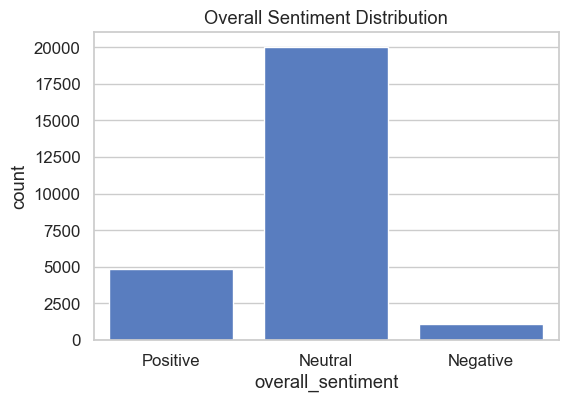

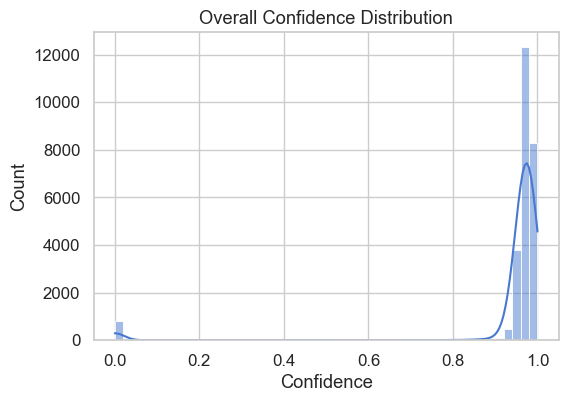

In [36]:
plt.figure(figsize=(6,4))
sns.countplot(x="overall_sentiment", data=df, order=["Positive","Neutral","Negative"])
plt.title("Overall Sentiment Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df["overall_confidence"], bins=50, kde=True)
plt.title("Overall Confidence Distribution")
plt.xlabel("Confidence")
plt.show()


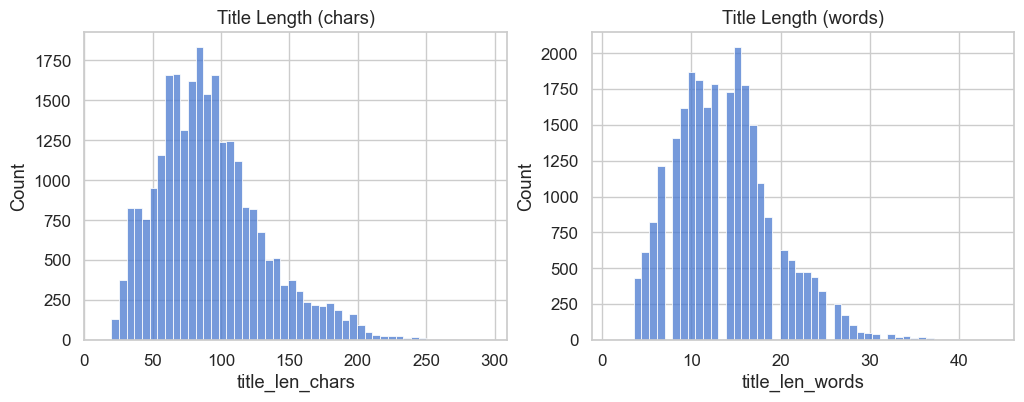

In [37]:
df["title_len_chars"] = df["title"].str.len()
df["title_len_words"] = df["title"].str.split().map(len)

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df["title_len_chars"], bins=50, ax=axes[0])
axes[0].set_title("Title Length (chars)")
sns.histplot(df["title_len_words"], bins=50, ax=axes[1])
axes[1].set_title("Title Length (words)")
plt.show()


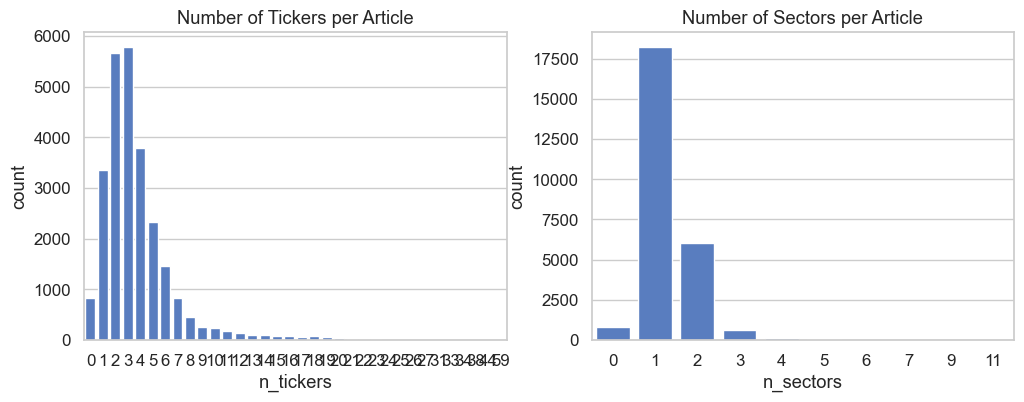

In [38]:
df["n_tickers"] = df["tickers"].map(len)
df["n_sectors"] = df["sectors"].map(len)

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x="n_tickers", data=df, ax=axes[0])
axes[0].set_title("Number of Tickers per Article")
sns.countplot(x="n_sectors", data=df, ax=axes[1])
axes[1].set_title("Number of Sectors per Article")
plt.show()


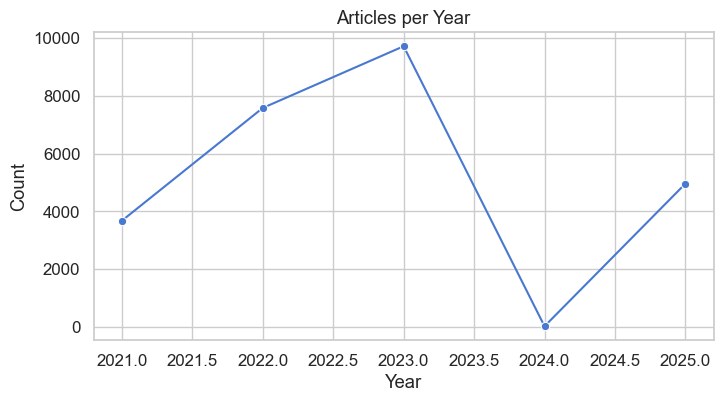

In [39]:
df["date"] = pd.to_datetime(df["date"])
yearly = df["date"].dt.year.value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.lineplot(x=yearly.index, y=yearly.values, marker="o")
plt.title("Articles per Year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.show()


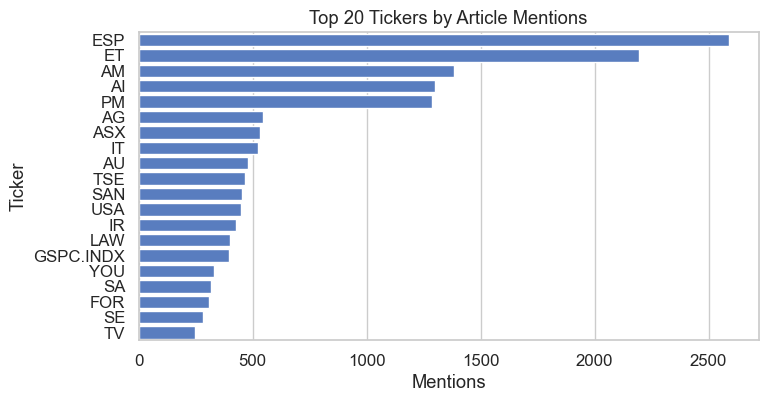

In [40]:
# 3.1 Flatten ticker list
tickers_flat = df["tickers"].explode().dropna().apply(pd.Series)

# 3.2 Top 20 tickers by article frequency
top20 = tickers_flat["symbol"].value_counts().head(20)
plt.figure(figsize=(8,4))
sns.barplot(x=top20.values, y=top20.index)
plt.title("Top 20 Tickers by Article Mentions")
plt.xlabel("Mentions")
plt.ylabel("Ticker")
plt.show()


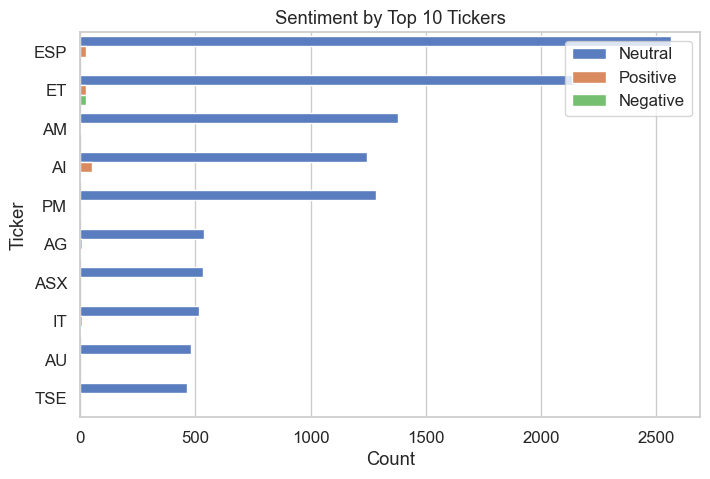

In [41]:
# 3.3 Sentiment breakdown per ticker (for top 10)
top_list = top20.index.tolist()[:10]
sub = tickers_flat[tickers_flat["symbol"].isin(top_list)]
plt.figure(figsize=(8,5))
sns.countplot(y="symbol", hue="label", data=sub, order=top_list)
plt.title("Sentiment by Top 10 Tickers")
plt.xlabel("Count")
plt.ylabel("Ticker")
plt.legend(loc="upper right")
plt.show()


In [42]:
# 3.4 Normalized sentiment ratio per ticker
ratio = (sub
         .groupby(["symbol","label"])
         .size()
         .unstack(fill_value=0)
         .pipe(lambda df2: df2.div(df2.sum(axis=1), axis=0)))
ratio.loc[top_list]


label,Negative,Neutral,Positive
symbol,,,
ESP,0.000000,0.990344,0.009656
ET,0.010483,0.979034,0.010483
AM,0.000000,0.998554,0.001446
AI,0.002311,0.959168,0.038521
PM,0.000776,0.998447,0.000776
AG,0.003650,0.981752,0.014599
ASX,0.000000,1.000000,0.000000
IT,0.005703,0.980989,0.013308
AU,0.000000,1.000000,0.000000


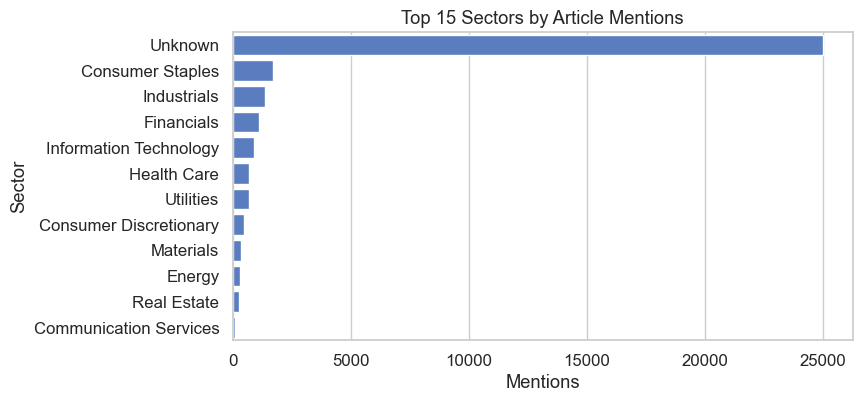

In [43]:
# 4.1 Flatten sectors
sectors_flat = pd.DataFrame(
	df["sectors"].explode().dropna().tolist()
)

# 4.2 Top sectors by mentions
topsec = sectors_flat["sector"].value_counts().head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=topsec.values, y=topsec.index)
plt.title("Top 15 Sectors by Article Mentions")
plt.xlabel("Mentions")
plt.ylabel("Sector")
plt.show()


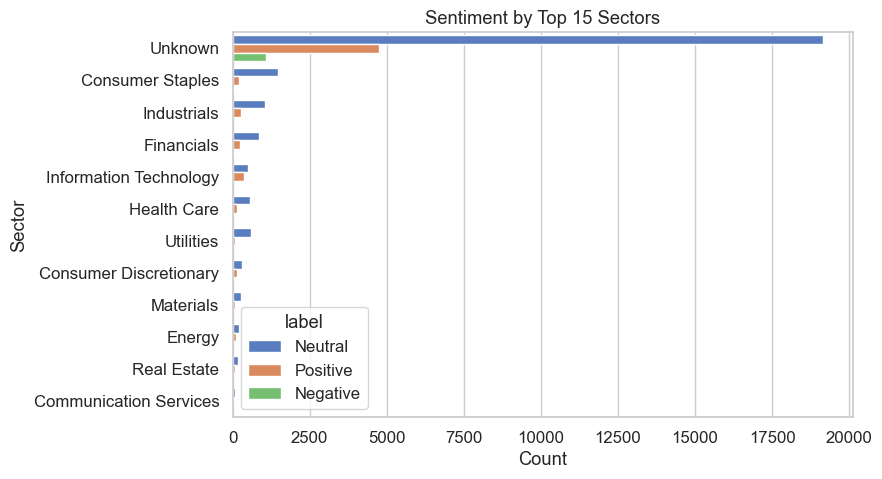

In [44]:
# 4.3 Sentiment breakdown for major sectors
maj = topsec.index.tolist()
sec_sub = sectors_flat[sectors_flat["sector"].isin(maj)]
plt.figure(figsize=(8,5))
sns.countplot(y="sector", hue="label", data=sec_sub, order=maj)
plt.title("Sentiment by Top 15 Sectors")
plt.xlabel("Count")
plt.ylabel("Sector")
plt.show()


In [45]:
# 4.4 Normalized sector sentiment ratios
ratio_sec = (sec_sub
             .groupby(["sector","label"])
             .size()
             .unstack(fill_value=0)
             .pipe(lambda df2: df2.div(df2.sum(axis=1), axis=0)))
ratio_sec.loc[maj]


label,Negative,Neutral,Positive
sector,,,
Unknown,0.043898,0.766226,0.189876
Consumer Staples,0.019042,0.854587,0.126370
Industrials,0.023307,0.769119,0.207575
Financials,0.032491,0.761733,0.205776
Information Technology,0.016667,0.570000,0.413333
Health Care,0.038997,0.768802,0.192201
Utilities,0.017266,0.867626,0.115108
Consumer Discretionary,0.051020,0.646939,0.302041
Materials,0.013550,0.731707,0.254743


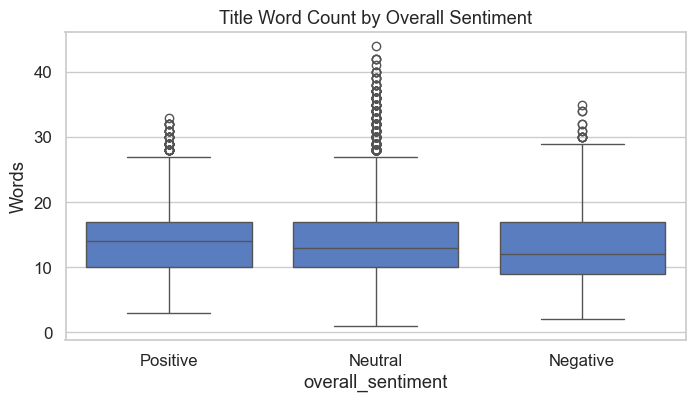

In [46]:
# Boxplot of title length by sentiment
plt.figure(figsize=(8,4))
sns.boxplot(x="overall_sentiment", y="title_len_words", data=df,
            order=["Positive","Neutral","Negative"])
plt.title("Title Word Count by Overall Sentiment")
plt.ylabel("Words")
plt.show()


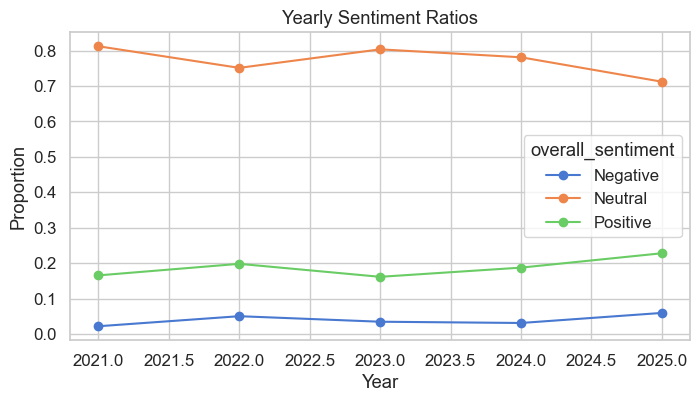

In [47]:
time_sent = (df
             .groupby([df["date"].dt.year, "overall_sentiment"])
             .size()
             .unstack(fill_value=0)
             .pipe(lambda x: x.div(x.sum(axis=1), axis=0)))
time_sent.plot(kind="line", marker="o", figsize=(8,4))
plt.title("Yearly Sentiment Ratios")
plt.ylabel("Proportion")
plt.xlabel("Year")
plt.show()


In [48]:
# Standard deviation of sentiment ratio across years
ticker_year = tickers_flat.copy()
ticker_year["year"] = df["date"].repeat(df["tickers"].str.len()).values
ty = (ticker_year
      .groupby(["symbol","year","label"])
      .size()
      .unstack(fill_value=0)
      .groupby(level=0)
      .apply(lambda d: d.div(d.sum(axis=1), axis=0))
      .groupby(level=0)
      .std())
ty["Positive"].sort_values(ascending=False).head(10)


symbol
1NBA.XETRA    0.707107
HZO           0.707107
VI1.F         0.707107
VAI.F         0.707107
AACA.F        0.707107
OGI.TO        0.707107
HMI.F         0.707107
1NBA.F        0.707107
EADSF.US      0.707107
LA5.F         0.707107
Name: Positive, dtype: float64